In [390]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
import pickle
from scipy.ndimage.measurements import label
from datetime import datetime

### Rubric 2.1 HOG features exploration

#### Loading data

In [391]:
# load the car and noncar data set (the file path)
def load_data(dataset="small"):
    if dataset == "small":
        images = glob.glob('./hog_test_images/**/**/*.jpeg')
        cars = []
        notcars = []
        for image in images:
            if 'non-vehicles_smallset' in image:
                notcars.append(image)
            else:
                cars.append(image)
    else:
        # Read in car and non-car images
        images = glob.glob('./hog_test_images/**/**/*.png')
        cars = []
        notcars = []
        for image in images:
            if 'non-vehicles' in image:
                notcars.append(image)
            else:
                cars.append(image)
    return cars, notcars

cars, notcars = load_data()

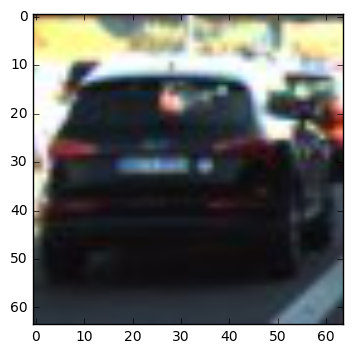

In [392]:
img = mpimg.imread(cars[np.random.randint(0, len(cars))])
plt.imshow(img)

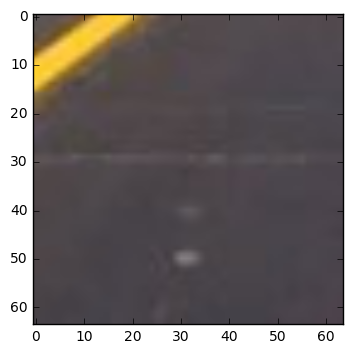

In [393]:
img = mpimg.imread(notcars[np.random.randint(0, len(notcars))])
plt.imshow(img)

#### Experimenting HOG parameters

In [203]:
# Define a functin to convert color space
def convert_color_space(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    return feature_image

# Define a function to return HOG features of specific channel and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2,
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def get_bin_spatial_features(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    feature_image = convert_color_space(img, color_space=color_space)
    if spatial_feat == True:
        spatial_features = get_bin_spatial_features(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = get_color_hist_features(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        img_features.append(hog_features)

    return np.concatenate(img_features)


# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                                           hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                           cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                           spatial_feat=spatial_feat, hist_feat=hist_feat,
                                           hog_feat=hog_feat)
        features.append(file_features)
    return features

In [222]:
# def a function to plot the images side by side
def plot_hog_images_by_channel(original, ch1, ch2, ch3):
    fig = plt.figure()
    plt.subplot(141)
    plt.imshow(original)
    plt.title('Original')
    plt.subplot(142)
    plt.imshow(ch1, cmap='gray')
    plt.title('Channel 1')
    plt.subplot(143)
    plt.imshow(ch2, cmap='gray')
    plt.title('Channel 2')
    plt.subplot(144)
    plt.imshow(ch3, cmap='gray')
    plt.title('Channel 3')

### Rubric 2.2 Exploring different HOG parameters

In [270]:
car_test_image = mpimg.imread(cars[np.random.randint(0, len(cars))])
noncar_test_image = mpimg.imread(notcars[np.random.randint(0, len(notcars))])

In [271]:
color_space = "RGB"
orient = 9
cell_per_block = 2
pix_per_cell = 8

1764


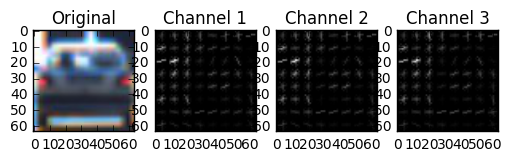

In [272]:
hog_feature, c_ch1 = get_hog_features(cs_cvted_image[:,:,0], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, c_ch2 = get_hog_features(cs_cvted_image[:,:,1], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, c_ch3 = get_hog_features(cs_cvted_image[:,:,2], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
plot_hog_images_by_channel(car_test_image, c_ch1, c_ch2, c_ch3)
print(len(hog_feature))

1764


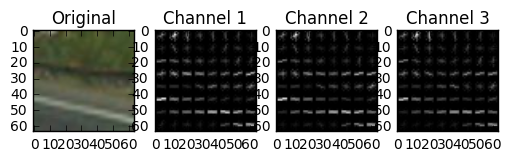

In [273]:
nc_cs_cvted_image = convert_color_space(noncar_test_image, color_space=color_space)
hog_feature, nc_ch1 = get_hog_features(nc_cs_cvted_image[:,:,0], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, nc_ch2 = get_hog_features(nc_cs_cvted_image[:,:,1], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, nc_ch3 = get_hog_features(nc_cs_cvted_image[:,:,2], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
plot_hog_images_by_channel(noncar_test_image, nc_ch1, nc_ch2, nc_ch3)
print(len(hog_feature))

In [312]:
color_space = "RGB"
orient = 9
cell_per_block = 2
pix_per_cell = 12

576


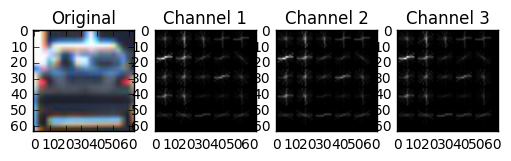

In [313]:
hog_feature, c_ch1 = get_hog_features(cs_cvted_image[:,:,0], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, c_ch2 = get_hog_features(cs_cvted_image[:,:,1], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, c_ch3 = get_hog_features(cs_cvted_image[:,:,2], orient=orient, 
                                      cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
plot_hog_images_by_channel(car_test_image, c_ch1, c_ch2, c_ch3)
print(len(hog_feature))

576


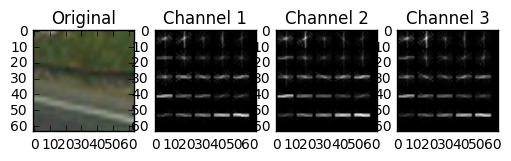

In [314]:
nc_cs_cvted_image = convert_color_space(noncar_test_image, color_space=color_space)
hog_feature, nc_ch1 = get_hog_features(nc_cs_cvted_image[:,:,0], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, nc_ch2 = get_hog_features(nc_cs_cvted_image[:,:,1], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
hog_feature, nc_ch3 = get_hog_features(nc_cs_cvted_image[:,:,2], orient=orient, 
                                       cell_per_block=cell_per_block, pix_per_cell=pix_per_cell, vis=True)
plot_hog_images_by_channel(noncar_test_image, nc_ch1, nc_ch2, nc_ch3)
print(len(hog_feature))

### Rubric 2.3, Defining the trainer

In [277]:
# Define a function to train
def train(car_features, notcar_features):
    # prepare data
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=89)
    print("Traing Sample %d, Test Sample %d" % (len(X_train), len(X_test)))
    print('Feature vector length:', len(X_train[0]))

    # define trainer
    svc = LinearSVC()
    t=time.time()
    svc.fit(X_train, y_train)
    print(round(time.time()-t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    return svc, X_scaler

In [360]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [361]:
# extract the features
t = time.time()
car_features = extract_features(cars, 
                                color_space=color_space, 
                                hog_feat=hog_feat,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                               )
notcar_features = extract_features(notcars, 
                                   color_space=color_space, 
                                   hog_feat=hog_feat,
                                   spatial_feat=spatial_feat,
                                   hist_feat=hist_feat,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins,
                                  )
print(time.time() - t)
print(car_features[0].shape)

20.04135799407959
(5340,)


In [362]:
svc, scaler = train(car_features, notcar_features)

Traing Sample 1856, Test Sample 465
Feature vector length: 5340
0.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9828


### Rubric 3.1 Perform sliding window search

In [383]:
x_start_stop = [800, 1280]
y_start_stop = [350, 650]
# xy_overlap = (0.9, 0.9)
xy_overlap = (0.9, 0.7)
xy_window = (128,64)
threshold = 3

In [284]:
# Define a function that takes an image, 
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# returns a list of windows 
def slide_window(img, 
                 x_start_stop, 
                 y_start_stop, 
                 xy_overlap,
                 xy_window):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Searching the sliding windows

In [285]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Time for seraching 1.876


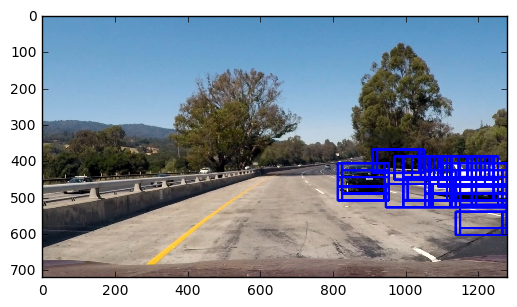

In [363]:
t = time.time()
test_image = mpimg.imread("./test_images/test1.jpg")
win_list = slide_window(test_image, 
                            x_start_stop,
                            y_start_stop,
                            xy_overlap,
                            xy_window=xy_window,
                            )
    
detected_window = search_windows(test_image, win_list, svc, scaler, 
                                 hog_feat=hog_feat,
                                 hist_feat=hist_feat,
                                 spatial_feat=spatial_feat,
                                 color_space=color_space,
                                 orient=orient,
                                 cell_per_block=cell_per_block,
                                 pix_per_cell=pix_per_cell,
                                 hog_channel=hog_channel,
                                 spatial_size=spatial_size,
                                 hist_bins=hist_bins
                                )

boxed_images = draw_boxes(test_image, detected_window)
plt.imshow(boxed_images)
print("Time for seraching %.3f" % (time.time() - t))

### Rubric 3.2 Defining the pipeline

In [368]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def clean(image, detected_window, threshold=3):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, detected_window)
    heat = apply_threshold(heat, threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return heatmap, draw_img, labels

In [369]:
def pipe_line(image, svc, scaler, 
                color_space,
                hog_feat,
                spatial_feat,
                hist_feat,
                orient,
                pix_per_cell,
                cell_per_block,
                hog_channel,
                spatial_size,
                hist_bins,
                x_start_stop,
                y_start_stop,
                xy_overlap, 
                xy_window,
                threshold=3):
            
    win_list = slide_window(image, 
                            x_start_stop,
                            y_start_stop,
                            xy_overlap,
                            xy_window=xy_window,
                            )
    
    detected_window = search_windows(image, win_list, svc, scaler, 
                                     hog_feat=hog_feat,
                                     hist_feat=hist_feat,
                                     spatial_feat=spatial_feat,
                                     color_space=color_space,
                                     orient=orient,
                                     cell_per_block=cell_per_block,
                                     pix_per_cell=pix_per_cell,
                                     hog_channel=hog_channel,
                                     spatial_size=spatial_size,
                                     hist_bins=hist_bins
                                    )
    boxed_images = draw_boxes(image, detected_window)
    heatmap, cleaned_image, lebels = clean(image, detected_window, threshold=threshold)
    return boxed_images, heatmap, cleaned_image, win_list, lebels

Time of Processing single image 2.000 


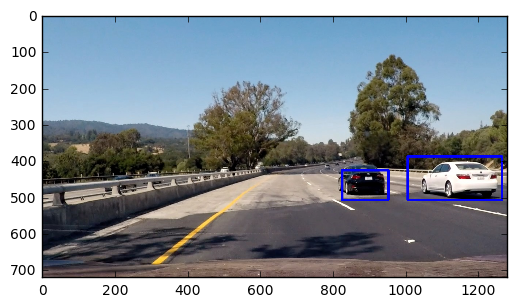

In [384]:
image = plt.imread("./test_images/test4.jpg")
t = time.time()
boxed, heat, cleaned, win_list, lebels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plt.imshow(cleaned)

### Rubric 4 Video output

In [58]:
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML

In [82]:
output_video = "output_video_" + str(datetime.today()) + ".mp4"
myclip = VideoFileClip("./project_video.mp4")
t = time.time()
processed_flips = []
for image in myclip.iter_frames():
    boxed, heat, cleaned = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                threshold=5)
    processed_flips.append(cleaned)
    
print("Time processing %.3f" % (time.time() -t ))
t = time.time()
output_clip = ImageSequenceClip(processed_flips,fps=25)
output_clip.write_videofile(output_video, audio=False)
print("Time storing %.3f" % (time.time() -t ))

KeyboardInterrupt: 

In [ ]:
output_video = "./output_video_2017-04-28 17:14:20.158105.mp4"
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

#### Printing the pipeline results

In [381]:
def plot_pipe_line_image(original, boxed, heatmap, cleaned):
    fig = plt.figure(figsize=(10,10))
    plt.subplot(141)
    plt.imshow(original)
    plt.title('Original')
    plt.subplot(142)
    plt.imshow(boxed)
    plt.title('Boxed Image')
    plt.subplot(143)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    plt.subplot(144)
    plt.imshow(cleaned)
    plt.title('Filtered')

Time of Processing single image 2.114 


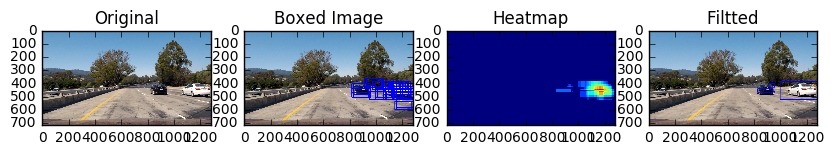

In [385]:
image = plt.imread("./test_images/test1.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)

Time of Processing single image 1.892 


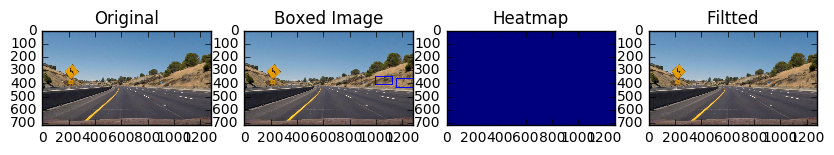

In [386]:
image = plt.imread("./test_images/test2.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)

Time of Processing single image 2.331 


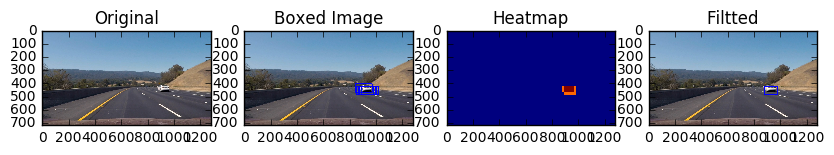

In [387]:
image = plt.imread("./test_images/test3.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)

Time of Processing single image 2.073 


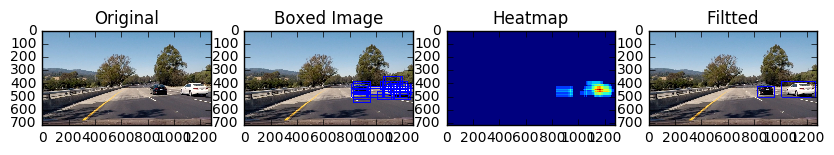

In [388]:
image = plt.imread("./test_images/test4.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)

Time of Processing single image 2.035 


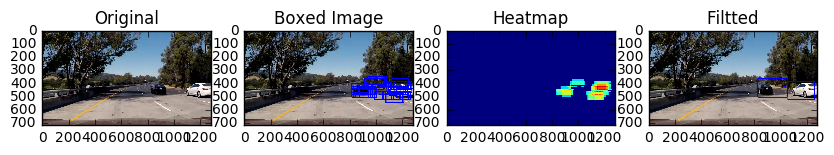

In [389]:
image = plt.imread("./test_images/test5.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)

Time of Processing single image 2.055 


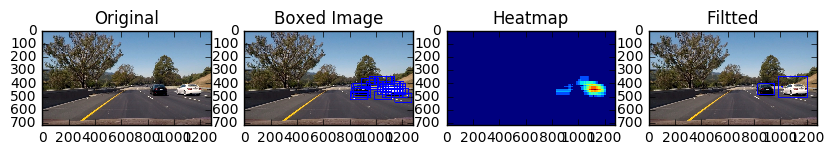

In [382]:
image = plt.imread("./test_images/test6.jpg")
t = time.time()
boxed, heat, cleaned, win_list, labels = pipe_line(image, svc, scaler, 
                                color_space,
                                hog_feat,
                                spatial_feat,
                                hist_feat,
                                orient,
                                pix_per_cell,
                                cell_per_block,
                                hog_channel,
                                spatial_size,
                                hist_bins,
                                x_start_stop,
                                y_start_stop,
                                xy_overlap,
                                xy_window,
                                threshold=threshold)
print("Time of Processing single image %.3f " % (time.time() - t))
plot_pipe_line_image(image, boxed, heat, cleaned)